## From Training to Prediction: Deploying a Rent Forecast Model with Ray Serve
In this notebook, we illustrate a streamlined workflow for **building a machine learning model** to forecast rental prices, **evaluating its accuracy**, and **deploying it for real-time predictions** using **Ray Serve**. The process unfolds as follows:

#### 1. Model Training:
We begin by training a **Random Forest model** on a simulated dataset of rental properties, capturing details like *square footage, bedrooms, bathrooms, and furnishing status* to predict monthly rent prices.

#### 2. Model Evaluation:
The model's predictive performance is assessed using **Mean Absolute Error (MAE)** on a subset of the data reserved for testing.

#### 3. Serialization and Deployment:
After training, **the model is saved to disk and deployed as a web service with Ray Serve**, which manages request handling and scalability.

#### 4. Real-time Predictions:
We conclude **by sending HTTP requests to the deployed model**, demonstrating how to obtain instant rent forecasts based on property features.

This workflow showcases the complete cycle from model development to deployment, providing a practical example of utilizing machine learning predictions in real-world applications.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Simulating dataset with 100 entries
np.random.seed(42)  # For reproducibility

square_footage = np.random.randint(500, 3000, 100)
bedrooms = np.random.randint(1, 5, 100)
bathrooms = np.random.randint(1, 4, 100)
furnished = np.random.randint(0, 2, 100)
monthly_rent = square_footage * 1 + bedrooms * 250 + bathrooms * 100 + furnished * 75 + np.random.randint(-250, 250, 100)

data = {
    'square_footage': square_footage,
    'bedrooms': bedrooms,
    'bathrooms': bathrooms,
    'furnished': furnished,
    'monthly_rent': monthly_rent
}
df = pd.DataFrame(data)

# Display the first few rows of the dataset
print(df.head())

   square_footage  bedrooms  bathrooms  furnished  monthly_rent
0            1360         2          3          0          2269
1            1794         1          2          1          2242
2            1630         4          3          1          3034
3            1595         3          3          1          2583
4            2138         3          2          1          3200


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [4]:
# Preparing input features and target variable
X = df.drop('monthly_rent', axis=1)
y = df['monthly_rent']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Date has been prepared.")

Date has been prepared.


In [5]:
# Training the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicting rent prices for the test set
y_pred = model.predict(X_test)

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: ${mae:.2f}")

Mean Absolute Error: $158.50


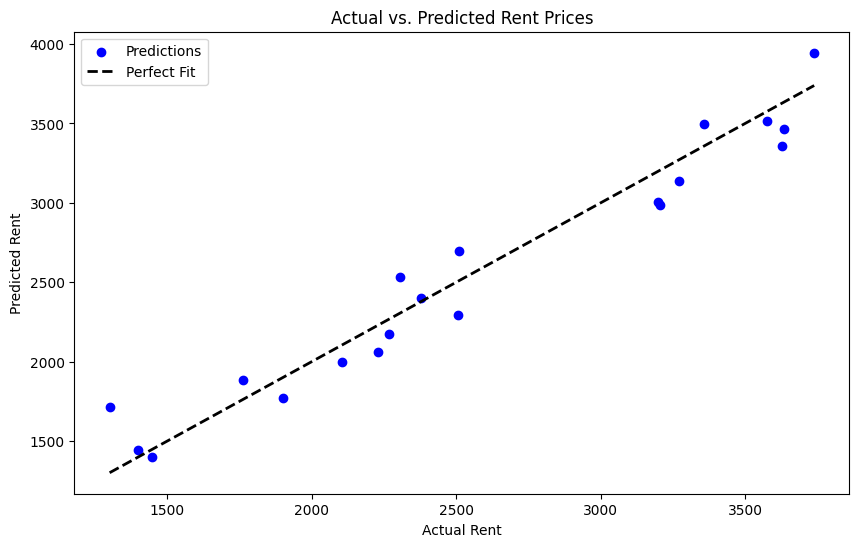

In [6]:
import matplotlib.pyplot as plt

# Actual vs. Predicted Rent Prices graph
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Fit')
plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.title('Actual vs. Predicted Rent Prices')
plt.legend()
plt.show()

In [7]:
from joblib import dump

# Dumping the model to deploy it with Ray-Serve
model_path = "rent_prediction_model.joblib"
dump(model, model_path)

['rent_prediction_model.joblib']

At this point, the model is ready. We will now deploy it using Ray Serve, where serving will be handled by a Ray Cluster deployed in EZAF. 

This section covers the necessary steps for initializing the Ray environment and starting Ray Serve with appropriate settings for smooth deployment and service operation.

In [8]:
# Building Ray Serve app
# !serve build <module_name>:<app_name> -o <config_file_name>.yaml
# This will generate config file
!serve build --app-dir "./" ray_serve_app:rent_predictor_app -o rent_predictor_app_config.yaml

Binding is completed.
2024-08-19 17:32:04,594	INFO handle.py:126 -- Created DeploymentHandle 'nttvkrg4' for Deployment(name='RentPredictor', app='app1').
2024-08-19 17:32:04,594	INFO handle.py:126 -- Created DeploymentHandle 'pfsh9unf' for Deployment(name='RentPredictor', app='app1').
2024-08-19 17:32:04,597	INFO scripts.py:848 -- The auto-generated application names default to `app1`, `app2`, ... etc. Rename as necessary.



## Attention! 
Following cell is a workaround. Currently, `serve deploy` does not support `--working-dir` directly.
Please see https://github.com/ray-project/ray/issues/29354

Suggested way to provide files from NB side to Ray cluster as below:
1. Create connection with `JobSubmissionClient` with working dir option but without entrypoint.
2. `JobSubmissionClient` will upload working_dir to GCS and print the URI.
3. Specify the above mentioned URI in config file as below example:
```
  runtime_env:
    working_dir: "gcs://_ray_pkg_fef565b457f470d9.zip"
```

In [2]:
# Workaround!
# This is to upload the working dir to GCS
# Once the URI is ready, please modify config dir before deployment
import ray
from ray.job_submission import JobSubmissionClient

ray_head_ip = "kuberay-head-svc.kuberay.svc.cluster.local"
ray_head_port = 8265
ray_address = f"http://{ray_head_ip}:{ray_head_port}"
client = JobSubmissionClient(ray_address)

job_id = client.submit_job(
    entrypoint="",
    runtime_env={
        "working_dir": "./",
    }
)

# We do not need this connection    
ray.shutdown()

2024-08-19 17:56:55,397	INFO dashboard_sdk.py:338 -- Uploading package gcs://_ray_pkg_c8acbba64acf4141.zip.
2024-08-19 17:56:55,399	INFO packaging.py:530 -- Creating a file package for local directory './'.


In [4]:
# Deploying the app
# Please avoid using "serve run" which uses deprecated client API "ray.init()" under the cover
# !serve run [OPTIONS] <config_file_name>.yaml
# Important! Please modify config file as described above to push working dir
!serve deploy --address "http://kuberay-head-svc.kuberay.svc.cluster.local:8265" rent_predictor_app_config.yaml

2024-08-19 17:58:03,923	INFO scripts.py:243 -- Deploying from config file: 'rent_predictor_app_config.yaml'.
2024-08-19 17:58:07,848	SUCC scripts.py:350 -- 
Sent deploy request successfully.
 * Use `serve status` to check applications' statuses.
 * Use `serve config` to see the current application config(s).



In [5]:
import requests

# Example request data
data = {
    "square_footage": 1200,
    "bedrooms": 2,
    "bathrooms": 2,
    "furnished": 1
}

# Sending a prediction request to Ray cluster where Serve is running
try:
    response = requests.post("http://kuberay-head-svc.kuberay.svc.cluster.local:8000/", json=data)
    print(response.json())
except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")

{'predicted_rent': 1861.12}


In [6]:
# Terminating the deployment
!serve shutdown --address "http://kuberay-head-svc.kuberay.svc.cluster.local:8265" -y

2024-08-19 17:59:35,229	SUCC scripts.py:747 -- Sent shutdown request; applications will be deleted asynchronously.
